<a href="https://colab.research.google.com/github/Jaimemorillo/covid-assignment/blob/main/survival_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/covid_assignment/COVID19_data.csv'

In [88]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

## Preprocessing

In [77]:
df = pd.read_csv(
    data_path,
    sep=',', 
    header='infer',
    index_col = "ID"
)
# remove DESTIONATION column
df.pop("DESTINATION")

# fetch categorical columns before doing any other preprocessing
cat_mask = (df.dtypes == object)
cat_cols= df.columns[cat_mask].tolist()

# remove all rows containing NA values (47 of them)
df = df.dropna()

# drop all rows where the important values are all 0
df.drop(df[(df["TEMP"] == 0) & (df["HEART_RATE"] == 0) &  (df["GLUCOSE"] == 0) & ( df["SAT_O2"] == 0) & (df["BLOOD_PRES_SYS"] == 0) & (df["BLOOD_PRES_DIAS"] == 0)].index)

# only remove the very big outliers, the smaller ones might be relevant
df = df.drop(df[(df["HEART_RATE"] > 400)].index)
df = df.drop(df[(df["BLOOD_PRES_SYS"] > 600)].index)
df = df.drop(df[(df["BLOOD_PRES_DIAS"] > 400)].index)
df = df.drop(df[(df["AGE"] > 180)].index)

# create 2 separate dataframes, categorical and numerical
df_cat = df[cat_cols]
df_num = df.drop(cat_cols, axis = 1)
# does a bit encoding for SEX and EXITUS
d = defaultdict(preprocessing.LabelEncoder)
df_cat_le = df_cat.apply(lambda col: d[col.name].fit_transform(col))

df = pd.merge(left = df_cat_le, right = df_num, on = "ID")


In [78]:
df

,SEX,EXITUS,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
ID,,,,,,,,,,,
1,0,0,15.0,4,0,37.0,0,0,92,0,0
2,0,0,18.0,4,0,37.3,105,0,97,0,0
3,1,0,21.0,7,0,38.5,112,0,95,85,47
4,1,0,21.0,10,0,39.2,113,0,97,0,0
5,1,0,22.0,4,0,36.3,80,0,92,111,70
...,...,...,...,...,...,...,...,...,...,...,...
2045,1,1,100.0,2,0,36.6,65,0,84,144,80
2046,0,1,101.0,2,0,36.8,84,0,95,110,65
2047,0,1,102.0,5,0,36.5,83,0,94,150,65


## Slipt train and test (test 20%)

Stardscaler is applied

In [89]:
X = df.drop(['EXITUS'], axis=1)
y = df['EXITUS'].values

# Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

print('Size train: ' + str(len(X_train)))
print('Size test: ' + str(len(X_test)))

Size train: 1601
Size test: 401


## Grid search and cross-validation

5-fold

In [90]:
parameters = {
              'C': [1, 0.1],
              'max_iter': [100, 300, 500],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

lr = LogisticRegression(random_state=9) ## Model
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=9),
             param_grid={'C': [1, 0.1], 'max_iter': [100, 300, 500],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

## Results

### Best params

In [91]:
print(clf.best_params_) #Best parameters selected
pd.DataFrame(clf.cv_results_) # Dataframe with every train

{'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043972,0.055418,0.000483,0.000010,1,100,newton-cg,"{'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
1,0.012378,0.006097,0.000483,0.000016,1,100,lbfgs,"{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
2,0.004189,0.000199,0.000583,0.000029,1,100,liblinear,"{'C': 1, 'max_iter': 100, 'solver': 'liblinear'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
3,0.016924,0.003811,0.000625,0.000045,1,100,sag,"{'C': 1, 'max_iter': 100, 'solver': 'sag'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
4,0.019835,0.001918,0.000671,0.000344,1,100,saga,"{'C': 1, 'max_iter': 100, 'solver': 'saga'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
5,0.016949,0.003575,0.000454,0.000018,1,300,newton-cg,"{'C': 1, 'max_iter': 300, 'solver': 'newton-cg'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
6,0.008853,0.000252,0.000423,0.000011,1,300,lbfgs,"{'C': 1, 'max_iter': 300, 'solver': 'lbfgs'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
7,0.003868,0.000216,0.000384,0.000014,1,300,liblinear,"{'C': 1, 'max_iter': 300, 'solver': 'liblinear'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
8,0.016719,0.003060,0.000560,0.000026,1,300,sag,"{'C': 1, 'max_iter': 300, 'solver': 'sag'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1
9,0.019166,0.004658,0.000430,0.000010,1,300,saga,"{'C': 1, 'max_iter': 300, 'solver': 'saga'}",0.847352,0.859375,0.859375,0.862500,0.818750,0.849470,0.016212,1


### Final metrics (test)

AUC: 0.877
Acc: 0.858
Precision: 0.688
Recall: 0.319
F1: 0.436
Conf. Matrix: 


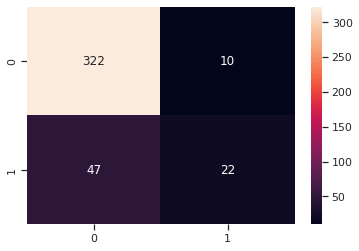

In [92]:
y_pred = clf.predict(X_test)
print('AUC: ' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]).round(3)))

def plot_metrics(y_test, y_pred):
  print('Acc: ' + str(accuracy_score(y_test, y_pred).round(3)))
  print('Precision: ' + str(precision_score(y_test, y_pred).round(3)))
  print('Recall: ' + str(recall_score(y_test, y_pred).round(3)))
  print('F1: ' + str(f1_score(y_test, y_pred).round(3)))
  print('Conf. Matrix: ')
  #print(confusion_matrix(y_test, y_pred))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

  return None

plot_metrics(y_test,y_pred)